In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pywt
import torch 
import scipy
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from hurst import compute_Hc, random_walk

In [2]:
temp_data = pd.read_csv('../Data/gsod_station_722860.csv')
temp_data = temp_data.iloc[:, 1:]
# Convert the 'date' column to datetime
temp_data['date'] = pd.to_datetime(temp_data['date'])
temp_data

,date,temp,max,min
0,1933-01-01,13.67,18.89,2.78
1,1933-01-02,13.89,19.61,1.89
2,1933-01-03,10.83,16.28,0.78
3,1933-01-04,14.94,21.28,1.28
4,1933-01-05,18.11,23.50,6.89
...,...,...,...,...
33646,2025-03-27,13.56,18.89,11.50
33647,2025-03-28,13.00,14.22,12.00
33648,2025-03-29,13.22,19.72,6.61
33649,2025-03-30,12.61,18.89,6.61


We skip the data analysis that is done in Main.ipynb

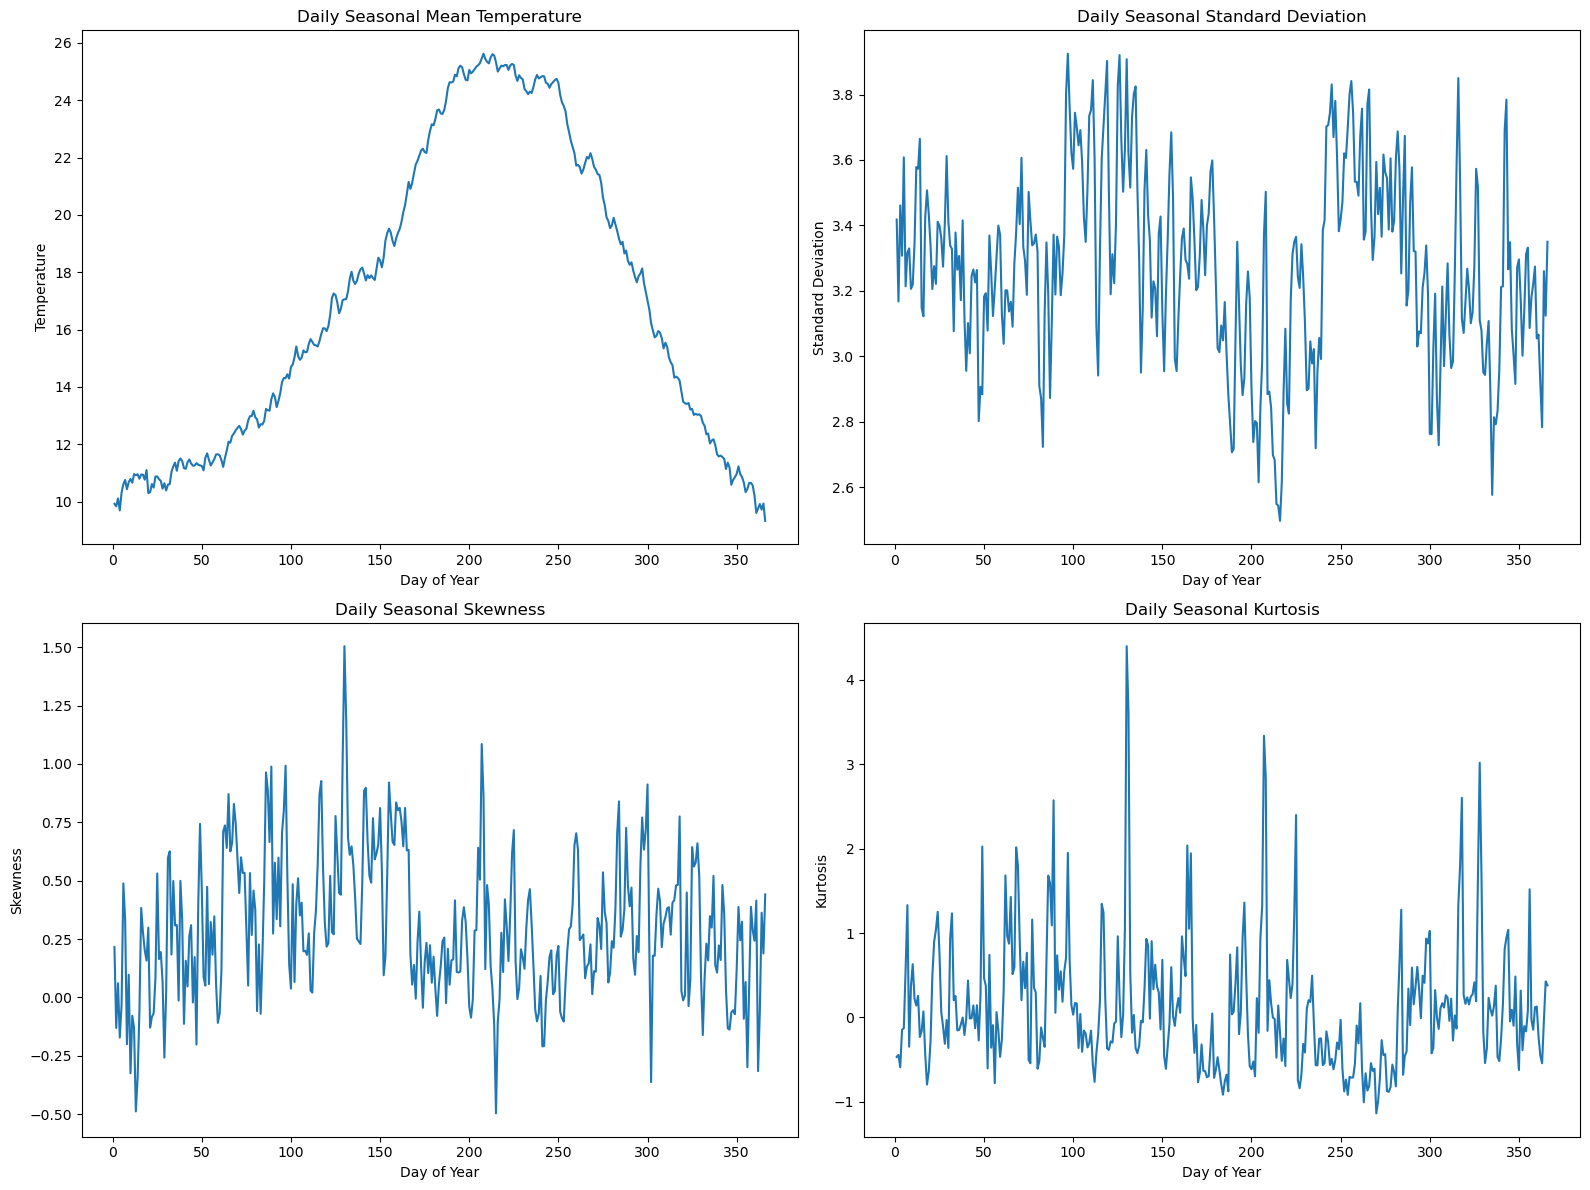

In [3]:
daily_seasonal_mean = temp_data.groupby(temp_data['date'].dt.dayofyear)['temp'].mean()
daily_seasonal_std = temp_data.groupby(temp_data['date'].dt.dayofyear)['temp'].std()
daily_seasonal_skew = temp_data.groupby(temp_data['date'].dt.dayofyear)['temp'].skew()
daily_seasonal_kurtosis = temp_data.groupby(temp_data['date'].dt.dayofyear)['temp'].apply(scipy.stats.kurtosis)

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
daily_seasonal_mean.plot(title='Daily Seasonal Mean Temperature')
plt.xlabel('Day of Year')
plt.ylabel('Temperature')

plt.subplot(2, 2, 2)
daily_seasonal_std.plot(title='Daily Seasonal Standard Deviation')
plt.xlabel('Day of Year')
plt.ylabel('Standard Deviation')

plt.subplot(2, 2, 3)
daily_seasonal_skew.plot(title='Daily Seasonal Skewness')
plt.xlabel('Day of Year')
plt.ylabel('Skewness')

plt.subplot(2, 2, 4)
daily_seasonal_kurtosis.plot(title='Daily Seasonal Kurtosis')
plt.xlabel('Day of Year')
plt.ylabel('Kurtosis')

plt.tight_layout()
plt.show()

# Detrend and deseasonalize (linear)
- Perform ADF and KPSS tests on the raw temperature data.
- Deseasonalize the temperature data by subtracting the daily seasonal mean.
- Perform ADF and KPSS tests on the deseasonalized temperature data.
- Detrend the time series using an OLS regression.
- Deseasonalize and whiten the detrended series.
- Perform ADF and KPSS tests on the deseasonalized and detrended series.
- Estimate the Hurst exponent of the original and processed series.
- Plot the ACF and PACF of the processed series.
      

In [4]:
# Function to perform the ADF test
def adf_test(series, title=''):
    print(f'ADF Test for {title}')
    result = adfuller(series.dropna())
    
    print('ADF Statistic: {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))
    
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}'.format(key, value))
    
    if result[1] <= 0.05:
        print("=> Reject the null hypothesis (H0). The data is stationary.")
    else:
        print("=> Failed to reject the null hypothesis (H0). The data is non-stationary.")
    print("\n")

# Function to perform the KPSS test
def kpss_test(series, title=''):
    print(f'KPSS Test for {title}')
    result = kpss(series.dropna())
    
    print('KPSS Statistic: {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))
    
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t{}: {:.4f}'.format(key, value))
    
    if result[1] <= 0.05:
        print("=> Reject the null hypothesis (H0). The data is non-stationary.")
    else:
        print("=> Failed to reject the null hypothesis (H0). The data is stationary.")
    print("\n")

# Perform tests on raw temperature data
adf_test(temp_data['temp'], "Raw Temperature Data")
kpss_test(temp_data['temp'], "Raw Temperature Data")



ADF Test for Raw Temperature Data
ADF Statistic: -14.8124
p-value: 0.0000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
=> Reject the null hypothesis (H0). The data is stationary.


KPSS Test for Raw Temperature Data
KPSS Statistic: 0.1395
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
=> Failed to reject the null hypothesis (H0). The data is stationary.




/var/folders/yt/tw36rldj4vj59zcpt_d9sjww0000gn/T/ipykernel_71976/1355883317.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna())


# WA seasonal mean removal

/opt/anaconda3/envs/Weather_Derivatives/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 11 is too high: all coefficients will experience boundary effects.
  warnings.warn(


ADF Test for Deseasonalized Temperature Data
ADF Statistic: -20.3895
p-value: 0.0000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
=> Reject the null hypothesis (H0). The data is stationary.


KPSS Test for Deseasonalized Temperature Data
KPSS Statistic: 0.1379
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
=> Failed to reject the null hypothesis (H0). The data is stationary.




/var/folders/yt/tw36rldj4vj59zcpt_d9sjww0000gn/T/ipykernel_71976/1355883317.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna())


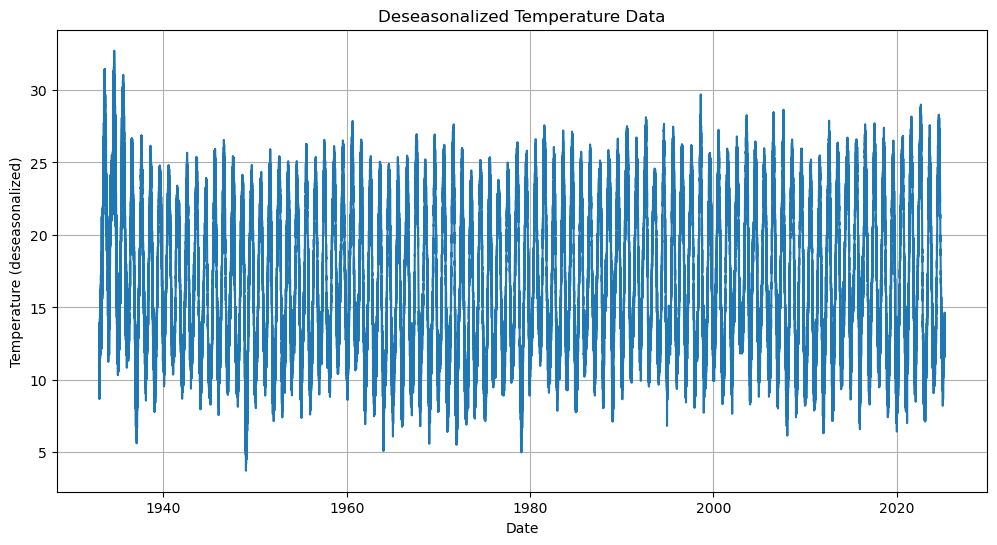

In [5]:
'''
# Create deseasonalized data using seasonal means
# First, add day of year to the dataframe
temp_data_with_day = temp_data.copy()
temp_data_with_day['dayofyear'] = temp_data_with_day['date'].dt.dayofyear

# Merge with seasonal means
seasonal_means = daily_seasonal_mean.reset_index()
seasonal_means.columns = ['dayofyear', 'seasonal_mean']
temp_data_with_day = pd.merge(temp_data_with_day, seasonal_means, on='dayofyear')

# Create deseasonalized series
deseasonalized = temp_data_with_day['temp'] - temp_data_with_day['seasonal_mean']
'''

from WA_seasonal_mean import remove_seasonality


deseasonalized= remove_seasonality(temp_data['temp'])

# Perform tests on deseasonalized data
adf_test(deseasonalized, "Deseasonalized Temperature Data")
kpss_test(deseasonalized, "Deseasonalized Temperature Data")

# Plot the deseasonalized data
plt.figure(figsize=(12, 6))
plt.plot(temp_data['date'], deseasonalized)
plt.title('Deseasonalized Temperature Data')
plt.xlabel('Date')
plt.ylabel('Temperature (deseasonalized)')
plt.grid(True)
plt.show()






# and detrend

In [ ]:
# Detrending the series
X = list(range(len(temp_data)))
y = temp_data['temp']
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
trend = results.predict(X)
detrended = temp_data['temp'] - trend

# Create temp_data_with_day dataframe
temp_data_with_day = temp_data.copy()
temp_data_with_day['dayofyear'] = temp_data_with_day['date'].dt.dayofyear
temp_data_with_day['detrended'] = detrended

# Deseasonalizing the detrended series using WA_seasonal_mean
from WA_seasonal_mean import remove_seasonality
deseasonalized_detrended = remove_seasonality(detrended)

# Alternative approach: If you prefer to use the original method with mean/std normalization:
# detrended_seasonal_mean = temp_data_with_day.groupby('dayofyear')['detrended'].mean()
# detrended_seasonal_std = temp_data_with_day.groupby('dayofyear')['detrended'].std()
# 
# seasonal_means_detrended = detrended_seasonal_mean.reset_index()
# seasonal_means_detrended.columns = ['dayofyear', 'seasonal_mean_detrended']
# temp_data_with_day = pd.merge(temp_data_with_day, seasonal_means_detrended, on='dayofyear')
# 
# seasonal_std_detrended = detrended_seasonal_std.reset_index()
# seasonal_std_detrended.columns = ['dayofyear', 'seasonal_std_detrended']
# temp_data_with_day = pd.merge(temp_data_with_day, seasonal_std_detrended, on='dayofyear')
# 
# deseasonalized_detrended = (temp_data_with_day['detrended'] - temp_data_with_day['seasonal_mean_detrended']) / temp_data_with_day['seasonal_std_detrended']

# Add processed series back to dataframe for reference
temp_data_with_day['deseasonalized_detrended'] = deseasonalized_detrended

hurst test to test understand the behaviour of the time series

ADF Test for Deseasonalized and Detrended Temperature Data
ADF Statistic: -16.5447
p-value: 0.0000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
=> Reject the null hypothesis (H0). The data is stationary.


KPSS Test for Deseasonalized and Detrended Temperature Data
KPSS Statistic: 1.1794
p-value: 0.0100
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
=> Reject the null hypothesis (H0). The data is non-stationary.


Hurst exponent of original series: 0.8688


/var/folders/yt/tw36rldj4vj59zcpt_d9sjww0000gn/T/ipykernel_69599/2795946612.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna())


Hurst exponent of processed series: 0.7234


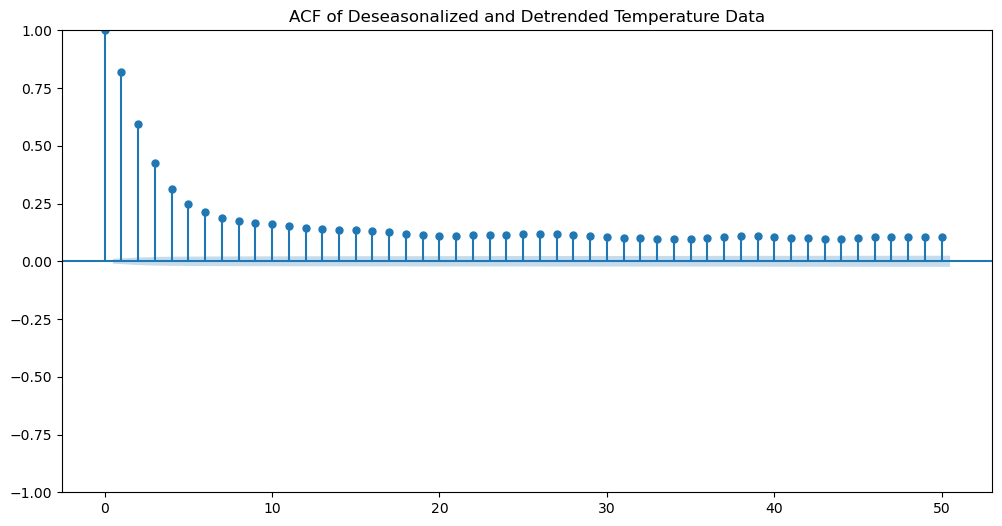

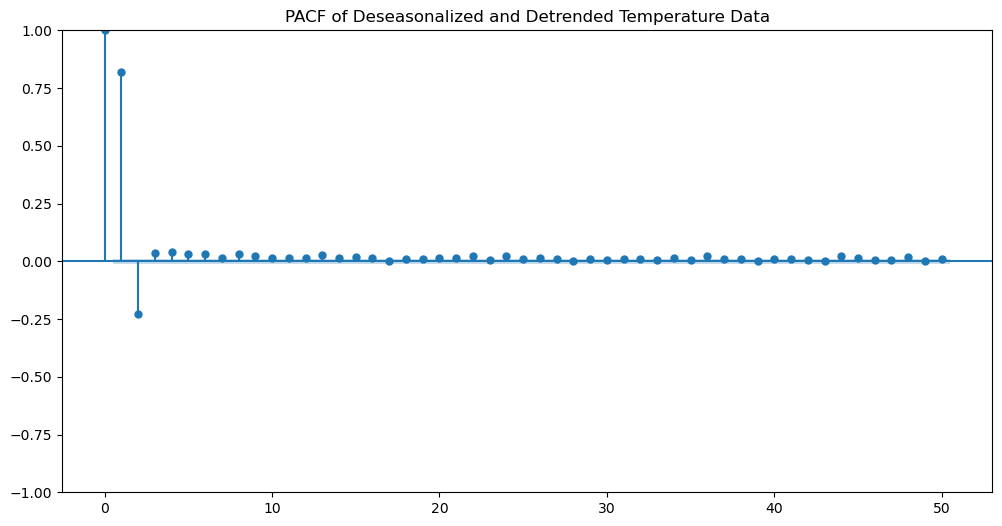

In [ ]:
from hurst import compute_Hc

# Unit root tests on the deseasonalized and detrended series
adf_test(deseasonalized_detrended, "Deseasonalized and Detrended Temperature Data")
kpss_test(deseasonalized_detrended, "Deseasonalized and Detrended Temperature Data")

# Hurst exponent estimation
H, c, val = compute_Hc(temp_data['temp'], kind='change', simplified=True)
print(f"Hurst exponent of original series: {H:.4f}")

H_processed, c_processed, val_processed = compute_Hc(deseasonalized_detrended.dropna(), kind='change', simplified=True)
print(f"Hurst exponent of processed series: {H_processed:.4f}")

# Autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(deseasonalized_detrended.dropna(), lags=50, ax=plt.gca())
plt.title('ACF of Deseasonalized and Detrended Temperature Data')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(deseasonalized_detrended.dropna(), lags=50, ax=plt.gca())
plt.title('PACF of Deseasonalized and Detrended Temperature Data')
plt.show()

# Optional: Visualize the original vs. detrended vs. fully processed data
plt.figure(figsize=(14, 8))
plt.plot(temp_data['date'], temp_data['temp'], label='Original Temperature')
plt.plot(temp_data['date'], detrended, label='Detrended Temperature')
plt.plot(temp_data_with_day['date'], deseasonalized_detrended, label='Detrended & Deseasonalized')
plt.title('Temperature Data Processing Comparison')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()